# Time series forecasting with DeepAR - Wikimedia pageview data

DeepAR is a supervised learning algorithm for forecasting scalar time series. This notebook demonstrates how to prepare a dataset of time series for training DeepAR and how to use the trained model for inference.

In [46]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
#from preprocessor import save_json

We will use the sagemaker client library for easy interface with sagemaker and s3fs for uploading the training data to S3. (Use `pip` to install missing libraries)

In [47]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.5.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [48]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Let's start by specifying:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the `get_execution_role` function to obtain the role arn which was specified when creating the notebook.

In [49]:
bucket = 'sagemaker-deepar20190120'
prefix = 'sagemaker/wiki-test-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [50]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Generating and uploading data

In this toy example we want to train a model that can predict the next 48 points of syntheticly generated time series.
The time series that we use have hourly granularity.

In [51]:
freq = 'H'
prediction_length = 48

We also need to configure the so-called `context_length`, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`. In our example we will use a longer `context_length` of `72`. Note that in addition to the `context_length` the model also takes into account the values of the time series at typical seasonal windows e.g. for hourly data the model will look at the value of the series 24h ago, one week ago one month ago etc. So it is not necessary to make the `context_length` span an entire month if you expect monthly seasonalities in your hourly data.

In [52]:
context_length = 72

Each time series will be a noisy sine wave with a random level. 

The following utility functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [53]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [54]:
import datetime
import requests
import json


def save_json(start, end, path):
    s3filesystem = s3fs.S3FileSystem()
    start_date = datetime.datetime.strptime(start, '%Y%m%d')
    end_date = datetime.datetime.strptime(end, '%Y%m%d')
    if (end_date - start_date).days < 0:
        raise Exception('start date should NOT after end date')

    # wiki all projects' page views by human (not web scraping) per hour on a day   
    base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/user/hourly/'
    data = dict()
    data['start'] = start_date.strftime('%Y-%m-%d') + ' 00:00:00'
    data['target'] = []
    delta = datetime.timedelta(days=199)
    x = 1
    while start_date <= end_date:
        print('<-----iteration ' + str(x) + ' starts----->')
        if start_date + delta <= end_date:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' + (start_date + delta).strftime('%Y%m%d') + '23'
        else:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' + end + '23'
        print (final_url)  # debug
        # use wiki api to get an hourly timeseries of all project's pageviews belonging to human users from start date
        # to end date
        r = requests.get(final_url)
        r.raise_for_status()
        output = r.json()
        print('processed data points: ' + str(len(output['items']))) 
        for i in range(len(output['items'])):
            data['target'].append(output['items'][i]['views'])
        start_date += datetime.timedelta(days=200)
        x += 1

    with s3filesystem.open(path, 'w') as outfile:
        json.dump(data, outfile)
        
        

In [55]:
train_start = '20150101'
train_end = '20171201'
save_json(train_start,train_end,s3_data_path + "/train/train.json")
test_start = '20180101'
test_end = '20181201'
save_json(test_start,test_end,s3_data_path + "/test/test.json")

<-----iteration 1 starts----->
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/user/hourly/2015010100/2015071923
processed data points: 456
<-----iteration 2 starts----->
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/user/hourly/2015072000/2016020423
processed data points: 4800
<-----iteration 3 starts----->
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/user/hourly/2016020500/2016082223
processed data points: 4800
<-----iteration 4 starts----->
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/user/hourly/2016082300/2017031023
processed data points: 4800
<-----iteration 5 starts----->
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/all-access/user/hourly/2017031100/2017092623
processed data points: 4800
<-----iteration 6 starts----->
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/all-projects/

### Train a model

We can now define the estimator that will launch the training job.

In [56]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

Next we need to set some hyperparameters: for example, frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options such as number of epochs, batch size, and learning rate. Refer to the documentation for a full description of the available parameters.

In [57]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [58]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last `prediction_length` points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [59]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-01-20-22-43-02-067


2019-01-20 22:43:02 Starting - Starting the training job...
2019-01-20 22:43:03 Starting - Launching requested ML instances......
2019-01-20 22:44:03 Starting - Preparing the instances for training.........
2019-01-20 22:45:52 Downloading - Downloading input data
2019-01-20 22:45:52 Training - Training image download completed. Training in progress.
Arguments: train
[01/20/2019 22:45:55 INFO 140526295103296] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[01/

[01/20/2019 22:46:08 INFO 140526295103296] Epoch[3] Batch[5] avg_epoch_loss=15.542376
[01/20/2019 22:46:08 INFO 140526295103296] Epoch[3] Batch [5]#011Speed: 185.97 samples/sec#011loss=15.542376
[01/20/2019 22:46:09 INFO 140526295103296] Epoch[3] Batch[10] avg_epoch_loss=15.490069
[01/20/2019 22:46:09 INFO 140526295103296] Epoch[3] Batch [10]#011Speed: 182.18 samples/sec#011loss=15.427299
[01/20/2019 22:46:09 INFO 140526295103296] processed a total of 321 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2274.75905418396, "sum": 2274.75905418396, "min": 2274.75905418396}}, "EndTime": 1548024369.584248, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548024367.309431}

[01/20/2019 22:46:09 INFO 140526295103296] #throughput_metric: host=algo-1, train throughput=141.107146855 records/second
[01/20/2019 22:46:09 INFO 140526295103296] #progress_metric: host=algo-1, completed 20 % of epochs
[01/20/2019 22:46:09 INFO 14052629

[01/20/2019 22:46:29 INFO 140526295103296] processed a total of 318 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2091.209888458252, "sum": 2091.209888458252, "min": 2091.209888458252}}, "EndTime": 1548024389.03932, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548024386.948049}

[01/20/2019 22:46:29 INFO 140526295103296] #throughput_metric: host=algo-1, train throughput=152.05714059 records/second
[01/20/2019 22:46:29 INFO 140526295103296] #progress_metric: host=algo-1, completed 65 % of epochs
[01/20/2019 22:46:29 INFO 140526295103296] loss did not improve
[01/20/2019 22:46:29 INFO 140526295103296] Epoch[13] Batch[0] avg_epoch_loss=15.060112
[01/20/2019 22:46:30 INFO 140526295103296] Epoch[13] Batch[5] avg_epoch_loss=15.104289
[01/20/2019 22:46:30 INFO 140526295103296] Epoch[13] Batch [5]#011Speed: 192.23 samples/sec#011loss=15.104289
[01/20/2019 22:46:31 INFO 140526295103296] Epoch[13] Batch[10] avg_epoch_loss


2019-01-20 22:47:00 Uploading - Uploading generated training model
2019-01-20 22:47:00 Completed - Training job completed
#metrics {"Metrics": {"get_graph.time": {"count": 1, "max": 4755.420207977295, "sum": 4755.420207977295, "min": 4755.420207977295}}, "EndTime": 1548024408.988955, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548024404.232671}

[01/20/2019 22:46:49 INFO 140526295103296] Number of GPUs being used: 0
#metrics {"Metrics": {"finalize.time": {"count": 1, "max": 5054.008007049561, "sum": 5054.008007049561, "min": 5054.008007049561}}, "EndTime": 1548024409.287497, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548024408.989087}

[01/20/2019 22:46:49 INFO 140526295103296] Serializing to /opt/ml/model/model_algo-1
[01/20/2019 22:46:49 INFO 140526295103296] Saved checkpoint to "/opt/ml/model/model_algo-1-0000.params"
#metrics {"Metrics": {"model.serialize.time": {"count

### Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note:** remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [60]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-01-20-22-43-02-067
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-01-20-22-43-02-067
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-01-20-22-43-02-067


-------------------------------------------------------------------------------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [61]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [62]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions and plot results

### Make prediction for `synthetic` data: sin() with noise.

Data contain 200 noisy time series, each consisting of 400 data points and with seasonality of 24 hours. 
All time series start at the same time point `t0`.

In [72]:
t0 = '2016-01-01 00:00:00'
data_length = 400
num_ts = 200
period = 24

In [78]:
time_series_synthetic = []
for k in range(num_ts):
    level = 100000 * np.random.rand()
    seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
    sig = 0.05 * level # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
    noise = sig*np.random.randn(data_length)
    data = source + noise
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
    time_series_synthetic.append(pd.Series(data=data, index=index))

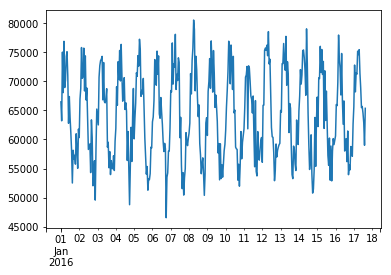

In [79]:
time_series_synthetic[0].plot()
plt.show()

In [80]:
time_series_to_predict = []
for ts in time_series_synthetic:
    time_series_to_predict.append(ts[:-prediction_length])

In [81]:
list_of_df = predictor.predict(time_series_to_predict[:5])
actual_data = time_series_synthetic[:5]

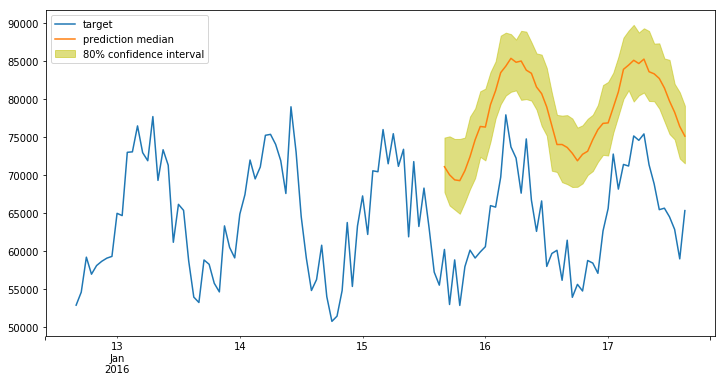

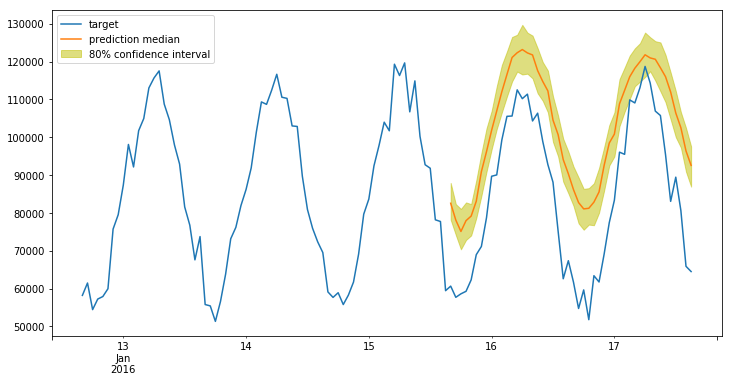

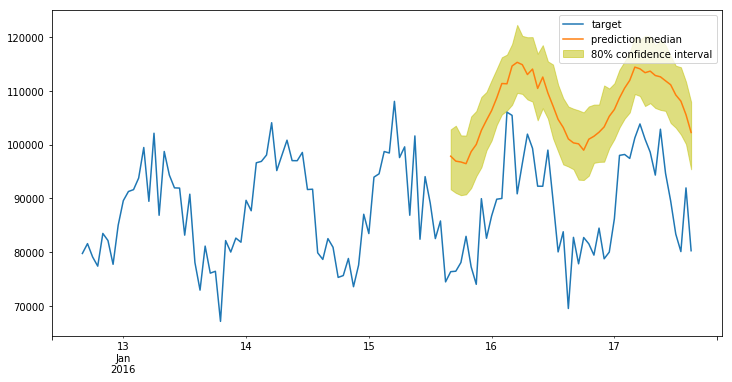

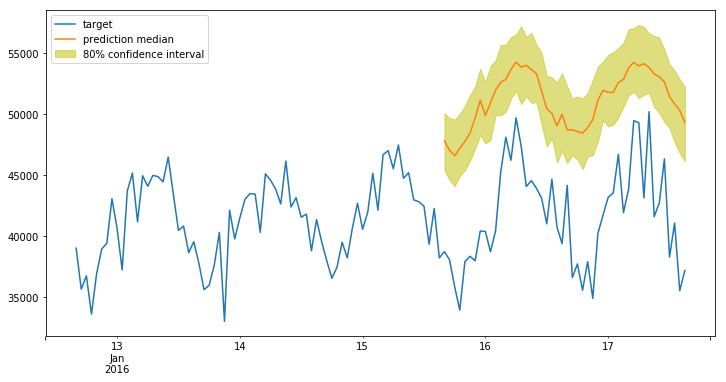

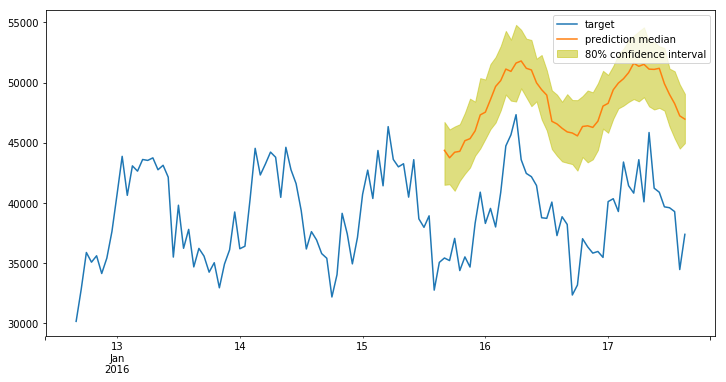

In [82]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Delete endpoint

In [105]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-01-20-22-43-02-067
